In [1]:
import re
import nltk
# nltk.download('book')
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key tex.usetex in file /home/rml/.config/matplotlib/matplotlibrc, line 1 ('tex.usetex: true')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [3]:
text1

<Text: Moby Dick by Herman Melville 1851>

In [4]:
text1.tokens[:10]

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.']

## Medidas estadísticas del texto

### Riqueza léxica

$$ R_i = \frac{\text{Total del palabra únicas}}{\text{Total de palabras}} = \frac{\text{Longitud de vocabulario}}{\text{Longitud de texto}} $$

In [5]:
vocabulario = set(text1)
len(vocabulario)

19317

In [6]:
rl = len(vocabulario)/len(text1)
rl

0.07406285585022564

### Porcentaje de palabra

In [7]:
text1.count("monster") / len(text1)

0.00018786974875296662

In [8]:
# slow
dic = {word: text1.count(word) for word in vocabulario}

In [9]:
fdist = FreqDist(text1)

In [10]:
fdist.most_common(5)

[(',', 18713), ('the', 13721), ('.', 6862), ('of', 6536), ('and', 6024)]

In [11]:
from collections import Counter

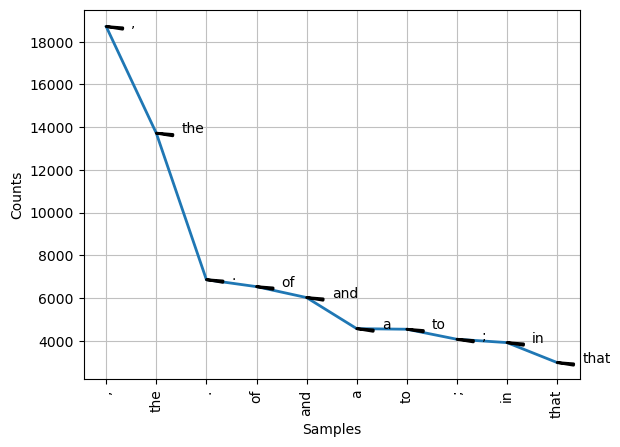

In [12]:
pl = fdist.plot(10, show=False)
data = pl.get_lines()[0].get_data()
ticks = pl.get_xticklabels()
for t, d in zip(ticks, list(zip(*data))):
    d = np.array(d)
    pl.annotate(t.get_text(), xy=d, xytext=d+.5, arrowprops=dict(facecolor='black', shrink=0.85, linewidth=2, headwidth=1))
plt.show()

## N-gramas

### Bi-gramas

In [13]:
bigramas = list(bigrams(text1))

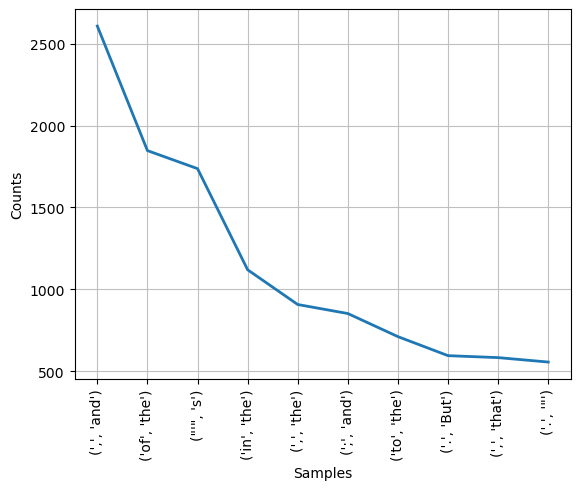

In [14]:
bi_freq = FreqDist(bigramas)
bi_freq.plot(10)
plt.show()

In [15]:
bi_freq.pprint(10)

FreqDist({(',', 'and'): 2607, ('of', 'the'): 1847, ("'", 's'): 1737, ('in', 'the'): 1120, (',', 'the'): 908, (';', 'and'): 853, ('to', 'the'): 712, ('.', 'But'): 596, (',', 'that'): 584, ('.', '"'): 557, ...})


In [16]:
bi_freq[(',', 'and')]

2607

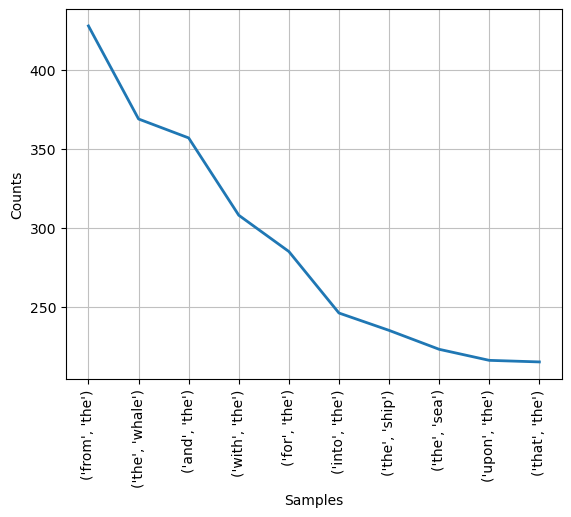

<Axes: xlabel='Samples', ylabel='Counts'>

In [17]:
threshold = 2
filtered_bi = FreqDist({bigram: bi_freq[bigram] for bigram in bi_freq.keys() if len(bigram[0]) > threshold and len(bigram[1]) > threshold})
filtered_bi.plot(10)

In [18]:
from nltk.util import ngrams

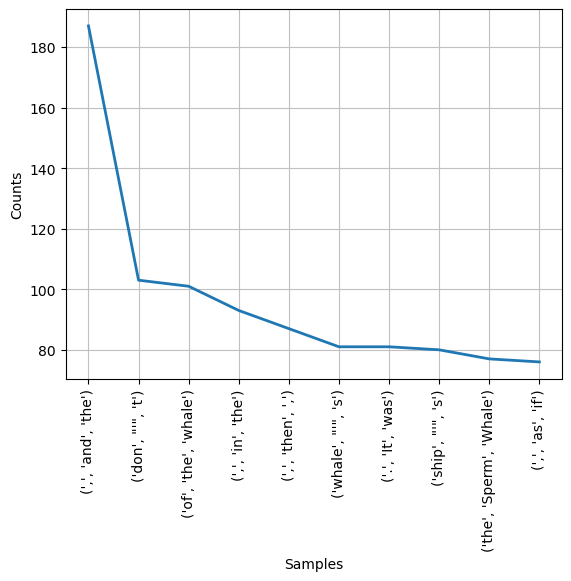

<Axes: xlabel='Samples', ylabel='Counts'>

In [19]:
trigrams = ngrams(text1, n=3)
tri_freq = FreqDist(trigrams)
tri_freq.plot(10)

## Colocaciones

In [20]:
bi_df = pd.DataFrame()
bi_df["bigrams"] = filtered_bi

In [21]:
# bi_df = bi_df.sort_values("bigrams", ascending=False)
bi_df

bigrams
Moby        Dick              83
Herman      Melville           1
Melville    1851               1
Late        Consumptive        1
Consumptive Usher              1
...                          ...
search      after              1
her         missing            1
missing     children           1
found       another            1
another     orphan             1

[67942 rows x 1 columns]

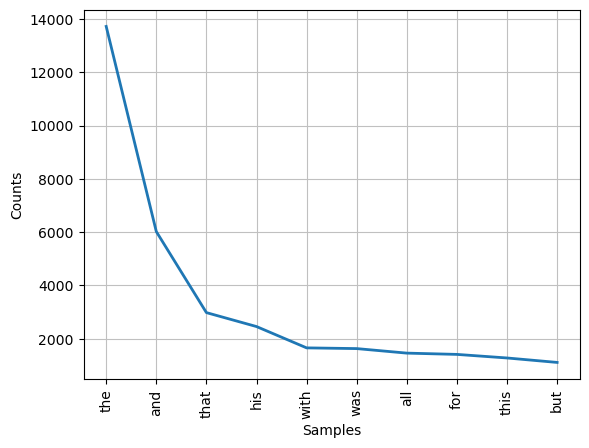

<Axes: xlabel='Samples', ylabel='Counts'>

In [22]:
filtered_fdist = FreqDist({word: fdist[word] for word in fdist.keys() if len(word) > threshold})
filtered_fdist.plot(10)

## Pointwise Mutual Information (PMI)

Una métrica útil para hallar colocaciones.

$$ \text{PMI} = \log{\left(\frac{P(w_1,w_2)}{P(w_1) P(w_2)}\right)} $$

In [23]:
bi_df = pd.merge(left=bi_df,
                 right=bi_df.apply(lambda x: { 'word_0': filtered_fdist[x.name[0]], "word_1": filtered_fdist[x.name[1]] } , axis=1, result_type='expand'),
                 left_index=True, right_index=True
                 )


In [24]:
bi_df["PMI"] = np.log2(bi_df.bigrams / ( bi_df.word_0 * bi_df.word_1 ) )

In [25]:
bi_df.loc['fierce', 'animal']

bigrams     1.000000
word_0     11.000000
word_1     16.000000
PMI        -7.459432
Name: (fierce, animal), dtype: float64

In [27]:
bi_df = bi_df.sort_values('PMI', ascending=False)

In [33]:
bi_df['log_bi'] = np.log2(bi_df.bigrams)
bi_df

bigrams  word_0  word_1        PMI  log_bi
gloomiest reserve           1       1       1   0.000000     0.0
Childe    Harold            1       1       1   0.000000     0.0
movingly  admonish          1       1       1   0.000000     0.0
warringly interweave        1       1       1   0.000000     0.0
lassitude overtakes         1       1       1   0.000000     0.0
...                       ...     ...     ...        ...     ...
man       the               1     508   13721 -22.732783     0.0
some      the               1     578   13721 -22.919024     0.0
one       the               1     889   13721 -23.540138     0.0
the       not               1   13721    1103 -23.851315     0.0
          but               1   13721    1113 -23.864336     0.0

[67942 rows x 5 columns]

# Análisis PMI

In [31]:
import plotly.express as px

In [41]:
fig = px.scatter(
    x='PMI',
    y='log_bi',
    color=bi_df['PMI'] + bi_df['log_bi'],
    hover_name=list(bi_df.index),
    data_frame=bi_df,
    height=600,
    width=500
)
fig.show()